# UK Covid-19 Modelling using SEIR

## Introduction

### The infection model

We begin with a standard SEIR model. This assumes the population can be divided four stages:
* **S**usceptible (i.e. not yet infected)
* **E**xposed (i.e. infected but not yet infectious)
* **I**nfectious (N.B. is not the same as ill)
* **R**emoved (N.B. these people may still be ill, but they are not infectious)

Members of the population move sequentially through the $S$-$E$-$I$-$R$ stages (modelled using exponential transitions), although there is a coupling term between the number of susceptibles $S$ and the proportion of currently infectious individuals $I/N$ that drives the first transition from $S$ to $E$. The full model equations (and some useful analytical results about the model and its extensions) may be found in [Lloyd (2009)](http://alun.math.ncsu.edu/wp-content/uploads/sites/2/2017/03/Lloyd_09.pdf).

There are 3 parameters to this model:
* $R_0$: this captures the infectiousness of the disease; it is the average number of new infections generated by an infected person while they are infectious. It is a both function of intrinsic properties of the contagion and the connectedness of the population -- hence can vary from region to region (or even between different population strata). Here we assume a single $R_0$ the entire population. However, we do make it time dependent to capture the impact of government interventions on population connectedness.
* $T_\mathrm{inc}$: this is the time-scale over which a newly infected person is incubating and not yet infectious.
* $T_\mathrm{inf}$: this is the time-scale over which an infected person is infectious -- i.e. capable of spreading the disease to susceptible members of the population. N.B. this is *not* the same as the time-scale over which a person is ill. It is also affected by how quickly and effectively symptomatic individuals choose to isolate (and by the proportion of infections that are symptomatic).

We fit initial values of these parameters to two observations: the rate of initial growth of infections in the country of interest and the mean serial interval for Covid-19. The second is solely a function of $T_\mathrm{inc}$ and $T_\mathrm{inf}$ (see [Svensson (2005)](https://www.sciencedirect.com/science/article/abs/pii/S0025556406002094?via%3Dihub)) whereas the first can be used to calibrate $R_0$ (where data from the beginning of the outbreak is available). Of course this leaves one free parameter, which can be taken to be the fraction $\frac{T_\mathrm{inc}}{T_\mathrm{inc}+T_\mathrm{inf}}$, i.e. the proportion of the mean serial interval for which individuals are not infectious. For our baseline calibration, we use the same division between latent and infectious phases as [Ferguson et al](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf), but we will analyse the sensitivity of model predictions to this parameter.

Afterwards, we also want to capture the time dependence of $R_0$ due to government intervention. From the timeline of government announcements, we assume the initial $R_0$ falls linearly between 10-26 March before plateauing at a new constant level representative of $R_0$ under current UK lockdown conditions. The dates of the linear decline in $R_0$ also match well [crowdsourced data](https://citymapper.com/cmi/london) on people's movements in London. The final level of $R_0$ is left to be calibrated to observational data.

There are some obvious variations to the model that could be explored. For example, setting $T_\mathrm{inc}$ to 0 leads to the simpler SIR model. This does make the unrealistic assumption that a person is infectious immediately after being infected themselves. But in turn one could model state any of the state transitions using gamma distributions (or more accurately as a multi-stage exponential process) to prevent transitions from occurring too quickly. One could also further compartmentalise the susceptible and infected populations depending on whether they are isolating or not, or according to other behaviour patterns that impact their susceptibility / propensity to infect, or to capture geographical variations.

### The observations model

Without timely, widespread and unbiased testing, none of the states $S$, $E$, $I$ and $R$ are directly observable (except of course prior to the outbreak). So, to fit the infection model to observations, we need a model to translate a given outbreak trajectory into observations.

The observations we use for this project are from the [John Hopkins University CSSE dataset](https://github.com/CSSEGISandData/COVID-19). In particular, we are interested in the timeseries available for numbers of confirmed cases and numbers of deaths per country (and sometimes region). Therefore, our observations model needs to estimate the progression of cases and deaths given a simulated trajectory for the infection.

Our model is constructed from the following assumptions:
1. Only a fraction $f_\mathrm{cdr}$ of actual cases are actually detected.
1. A fraction $f_\mathrm{cfr}$ of actual cases lead to death.
1. There is a time delay between a person being infected and a positive test being recorded. This in turn leads to a lag between observed case statistics and when those infections actually happened. This time delay is assumed to be random and modelled by a gamma distribution with mean time $T_\mathrm{detect}$. However it can be made deterministic by setting the gamma shape parameter high enough.
1. There is a time delay between a person becoming a confirmed case and them either recovering or dying. These are captured by gamma distributions with mean times $T_\mathrm{recover}$ and $T_\mathrm{death}$; again both can be made effectively deterministic by a sufficient choice of shape parameter. It is necessary to model both these delays in order to estimate the number of active cases (and in turn the burden on the healthcare system) at any point in time, as well as to fit to observed deaths data.

And here are some limitations from the way the model is currently set up:
1. For the sake of simplicity, we do not model hospitalisations separately: at least in the UK in March, the vast majority of testing was done at hospitals, and only a minority was performed on healthcare workers, so we assume that all detected cases were hospitalised. This assumption could easily be loosened (and indeed needs to be as the testing strategy changes).
1. At the moment all of the model parameters are constant; however, some of them do need to be made time dependent to capture e.g. changes in testing strategy.
1. $T_\mathrm{death}$ above is not the time to death itself but the time to the death appearing in publish statistics. This may therefore lead to overestimation of the number of the healthcare burden.

For our **baseline** scenario, we set these parameters as follows:
1. We assume that $f_\mathrm{cdr}=4.4\%$ and $f_\mathrm{cfr}=0.9\%$ to be consistent with the [Ferguson et al](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf) paper that drove the government's intervention strategy.
1. We use the following time-scales for case detection, recovery and death: $T_\mathrm{detect}=11$ (roughly the time between infection and hospitalisation according to Ferguson), $T_\mathrm{recover}=8$ and $T_\mathrm{death}=10$. We set the shape parameters to capture a wider spread in times to death than times to recovery and also the fact that detection can't happen too soon after infection. We also tried to set these parameters to at least approximately capture Ferguson's projections for active cases and daily death counts for the purpose of creating a baseline scenario.

Overall, all these parameters are subject to judgement, and the sensitivity of model projections to these assumptions needs to be assessed. However it is important to keep in mind that the aim here is to create a baseline set of parameters, roughly consistent with government modelling, which can then be flexed to investigate alternative scenarios.

Let's begin.

## Load packages and modules

Create a new code cell and run the following code only if you haven't got these packages already installed

```
%%bash
pip install --upgrade pip
pip install numpy==1.18.2
pip install pandas==1.0.3
pip install scipy==1.4.1
pip install matplotlib==3.2.1
pip install seaborn==0.10.0```

Then let's load required modules. Note that `outbreak_modelling` contains the model code; `jhdatautils` contains some helper functions for using the CSSE dataset; and `plotutils` contains some custom functions for plotting simulation results.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar
from scipy.stats import gamma
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import os
from collections import namedtuple
from copy import copy
from outbreak_modelling import *
from plotutils import *
from jhdatautils import *

In [3]:
sns.set(style='whitegrid', palette='deep')

## Load observations

We load observations from the John Hopkins CSSE dataset. This contains data for multiple countries but the code below has currently only been tested on UK data.

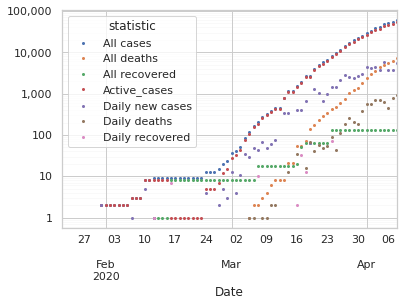

In [4]:
data = load_data()
ts = single_country_data(data, 'United Kingdom', ('2020/03/01', '2020/03/16'))
ts.to_csv('simdata/uk-observations-used-for-simulation.csv')
ts.plot(marker='o', ls='', markersize=2)
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=range(10)))
plt.gca().grid(which='minor', axis='y', alpha=0.1)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

We see that for the UK, daily growth during the uncontained period of the outbreak (early March) is about 30%:

In [5]:
def estimate_growth(data, column):
    return data[column][data[column]>0].pct_change().median()

c_growth = estimate_growth(ts[ts['phase']=='unrestricted'], 'All cases')
d_growth = estimate_growth(ts[ts['phase']=='unrestricted'], 'All deaths')
print('Cases growth rate: {:.2%}'.format(c_growth))
print('Deaths growth rate: {:.2%}'.format(d_growth))

Cases growth rate: 27.50%
Deaths growth rate: 33.33%


Using $T_\mathrm{inc}$ and $T_\mathrm{inf}$ choices above, this implies an initial $R_0$ of around 3-3.5:

In [6]:
SEIRModel.calibrate_parameters(early_growth_rate=0.3,
                               mean_generation_time=6.5,
                               lat_fraction=0.71)

{'R_0': 3.30418237690366, 'T_inc': 4.615, 'T_inf': 1.8849999999999998}

Note that this is somewhat higher than the Imperial College group's [original paper](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf) ($R_0 = 2.4$), but is a bit lower than the same group's [latest estimate](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-Europe-estimates-and-NPI-impact-30-03-2020.pdf), which is closer to 4 for the UK. The former is because they initially based their estimate on observations from Wuhan; the latter may be because their latest analysis uses a SIR-type model with gamma transitions: using a gamma distribution tends to increase the $R_{0}$ required to capture the same growth rate (keeping the serial interval fixed). Also, the more recent analysis is calibrated to deaths, where there are some timing issues (discussed below) that lead to a slightly higher apparent growth rate.

## The baseline models

### An unconstrained epidemic

Here is a constant-$R_0$ baseline model *for an unconstrained outbreak*, only fit to data until mid-March. This shows a projection of what would have happened if interventions had not been put in place, and making the model assumptions listed above:

SEIR model parameters: {'R_0': 2.966877321936954, 'T_inc': 4.615, 'T_inf': 1.8849999999999998}
Fit score: 12.38%


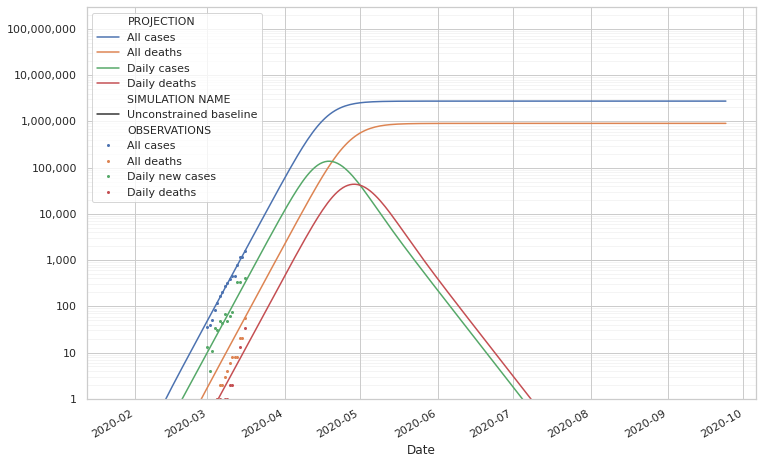

In [7]:
SEIR_parameters = SEIRModel.calibrate_parameters(0.26, 6.5, 0.71)
SEIRObs_parameters = {'f_cdr':0.044, 'f_cfr':0.33,
                      'cv_detect':1/3, 'T_detect':11,
                      'cv_resolve':1/3, 'T_resolve':9,
                      'cv_death':1/5, 'T_death':10,
                      'early_growth_rate':0.26,
                      'mean_generation_time':6.5,
                      'lat_fraction':0.71,
                      'initial_state':SEIR.make_state(S=6.64e7, I=1)}
print('SEIR model parameters:', SEIR_parameters)
unc_model = SEIRObsModel(start_date='2020/02/01', **SEIRObs_parameters)
score = unc_model.fit_score(ts['All cases'][ts['phase']=='unrestricted'],
                            ts['All recovered'][ts['phase']=='unrestricted'],
                            ts['All deaths'][ts['phase']=='unrestricted'],
                            2*365//3, weights=[1., 0., 0.])
print('Fit score: {:0.2%}'.format(score))
sim_baseline = unc_model.predict(2*365//3)
sim_baseline.to_csv('simdata/sim-baseline-parameters.csv')
plot_simulations({'Unconstrained baseline': sim_baseline},
                 ts[ts.phase=='unrestricted']);

Under this scenario there are about half a million deaths in total.

### Simulate lockdown

Now we assume $R_0$ linearly declines from around 10 March to 26 March.

Unmitigated fit: 29.60%
Lockdown fit: 14.97%


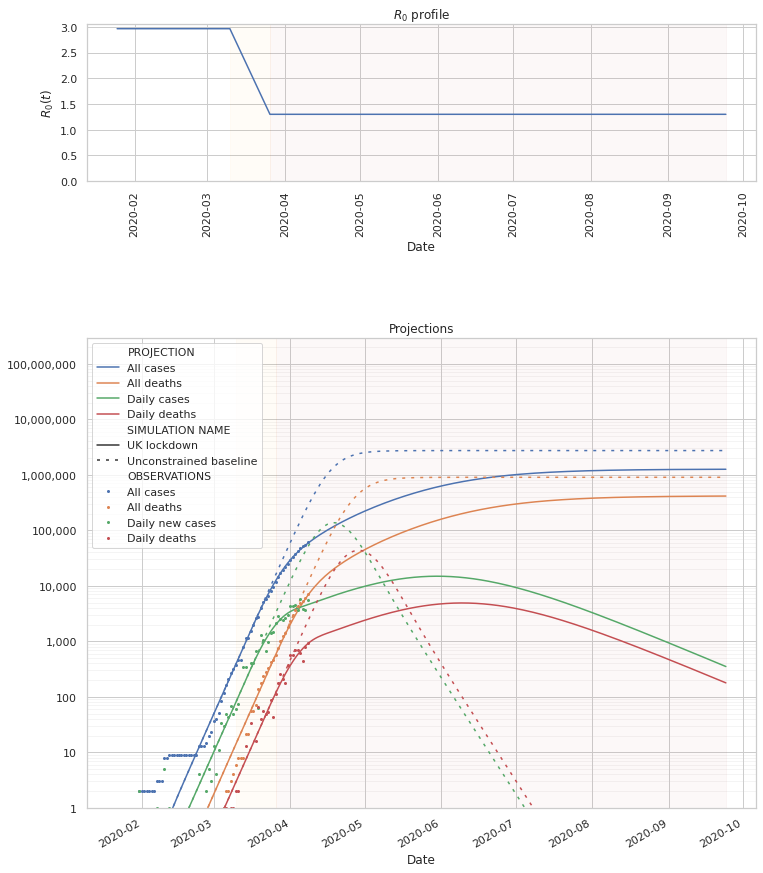

In [8]:
R_0_final = 1.3
R_0_ld = piecewise_linear_R_0_profile(['2020/03/10', '2020/03/26'],
                                      [unc_model.R_0(0), R_0_final],
                                      sim_baseline)
ld_model = SEIRObsModel(start_date=unc_model.start_date,
                        **SEIRObs_parameters)
ld_model.R_0 = R_0_ld
unc_score = unc_model.score(ts['All cases'], ts['All recovered'],
                            ts['All deaths'],
                            2*365//3, weights=[1., 0., 0.])
ld_score = ld_model.score(ts['All cases'], ts['All recovered'],
                            ts['All deaths'],
                            2*365//3, weights=[1., 0., 0.])
print("Unmitigated fit: {:0.2%}".format(unc_score))
print("Lockdown fit: {:0.2%}".format(ld_score))
sim_ld = ld_model.predict(2*365//3)
assert ((sim_baseline.index - sim_ld.index).to_series().dt.days==0).all(), (sim_baseline.index[:5], sim_ld.index[:5])
_, (axt, axb) = plt.subplots(2, 1, figsize=(12, 16),
                             gridspec_kw={'height_ratios': [1, 3]})
plt.sca(axt)
plt.plot(sim_baseline.index, R_0_ld(range(len(sim_baseline))))
plt.ylim(0, None)
plt.ylabel('$R_0(t)$')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.title('$R_0$ profile')
plot_data = plot_simulations({'UK lockdown': sim_ld,
                              'Unconstrained baseline': sim_baseline},
                             ts, ax=axb)
axb.set_title('Projections')
for ax in (axt, axb):
    ax.axvspan(pd.to_datetime('2020/03/10'),
               pd.to_datetime('2020/03/26'), color='orange', alpha=0.03)
    ax.axvspan(pd.to_datetime('2020/03/26'),
               sim_ld.index[-1], color='r', alpha=0.04)
plt.subplots_adjust(hspace=0.5)
plot_data.to_csv('simdata/sim-lockdown-final-R0-{}.csv'.format(R_0_final))

Notice that the peak is brought slightly forward, but is most importantly a lot lower. According to this projection, the total number of death is likely to be around 15,000 (if the lockdown were to persist until mid-summer). Furthermore, the daily death rate (averaged for timing jitter) should peak at around a few hundred in early-to-mid April and then decline. These don't look that far off current government estimates.

## Interactive plot

Here is an interactive version of the above code, to allow you to play parameters directly (N.B. this won't appear in the HTML export of this notebook). The $R_0$ profile is also charted below. The controls allow you to release the lockdown on a specified date, after which $R_0$ linearly ramps up to its original value over a specified number of weeks.

In the charts below, the lockdown period is shaded red and the lockdown release period is shaded green.

In [9]:
last_simulation = interactive_simulation(ts)
display(last_simulation)

interactive(children=(FloatSlider(value=26.0, description='Initial growth rate, %', layout=Layout(width='500px…

In [10]:
last_simulation.result

## Still to-do
* Comparison to alternative scenarios where the case detection rate is a lot lower than assumed in government estimates.
* Projection of what may happen under different lockdown lifting strategies (e.g. a sudden lifting of all restrictions after 3 months, a linear increase in $R_0$ after 3 months, etc).
* Use the above to estimate how slowly $R_0$ can be increased back to its "natural" level in order to implement a "mitigate" strategy while keeping daily cases/deaths at an acceptable level.
* Sensitivity analysis to model parameters - in particular the latency proportion and the gamma shape parameters (can these be dropped?).